In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from src.admm_model import ADMM_Net
from src.fn import *
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [16]:
psf = r'/Users/qiujinyu/Computational_Imaging/ADMMbyQJY/data/2025-10-19-exp001/001-psf-oTLc.jpg'
measurement = r"/Users/qiujinyu/Computational_Imaging/ADMMbyQJY/data/2025-10-19-exp001/013-m-Qh73.jpg"
downsample = 16

iterations  = 300
tau_scale   = 1000

ground_truth_file = None                                                        # 设置为 None 的时候不显示
save_dir = r"/Users/qiujinyu/Computational_Imaging/ADMMbyQJY/pic"               # 设置为 None 的时候不保存
save_name = {
    "gt": "gt.png",
    "psf": "psf.png",
    "meas": "m.png",
    "recon": "r.png"
}

In [17]:
psf_resized = load_and_downsample_normal2_image(
    psf,
    downsample=downsample,
    mode="gray",
    remove_bg=True,
    normalize=True,
    visualize=False
)
measurement_resized = load_and_downsample_normal2_image(
    measurement,
    downsample=downsample,
    mode="rgb",
    remove_bg=False,
    normalize=True,
    visualize=False
)
measurement_resized = measurement_resized.transpose((2, 0, 1))  # 转为 (C, H, W)

print(f"psf_resized: shape={psf_resized.shape}, dtype={psf_resized.dtype}, min={psf_resized.min():.3f}, max={psf_resized.max():.3f}")
print(f"measurement_resized: shape={measurement_resized.shape}, dtype={measurement_resized.dtype}, min={measurement_resized.min():.3f}, max={measurement_resized.max():.3f}")


psf_resized: shape=(228, 342), dtype=float64, min=-0.000, max=0.014
measurement_resized: shape=(3, 228, 342), dtype=float64, min=0.001, max=0.003


In [18]:
input_tensor = (
    torch.from_numpy(measurement_resized.copy())
    .float()
    .unsqueeze(0)
    .to(device)
)

admm_net = ADMM_Net(psf_resized, iterations, device)
admm_net.tau.data *= tau_scale
admm_net.to(device)

admm_net.eval()
with torch.no_grad():
    output_tensor = admm_net(input_tensor)

print(f"input Tensor: shape={input_tensor.shape}, dtype={input_tensor.dtype}, min={input_tensor.min():.3f}, max={input_tensor.max():.3f}")
print(f"output Tensor: shape={output_tensor.shape}, dtype={output_tensor.dtype}, min={output_tensor.min():.3f}, max={output_tensor.max():.3f}")

reconstruction = output_tensor[0].cpu().numpy().transpose(1, 2, 0)

input Tensor: shape=torch.Size([1, 3, 228, 342]), dtype=torch.float32, min=0.001, max=0.003
output Tensor: shape=torch.Size([1, 3, 228, 342]), dtype=torch.float32, min=-0.092, max=1.000


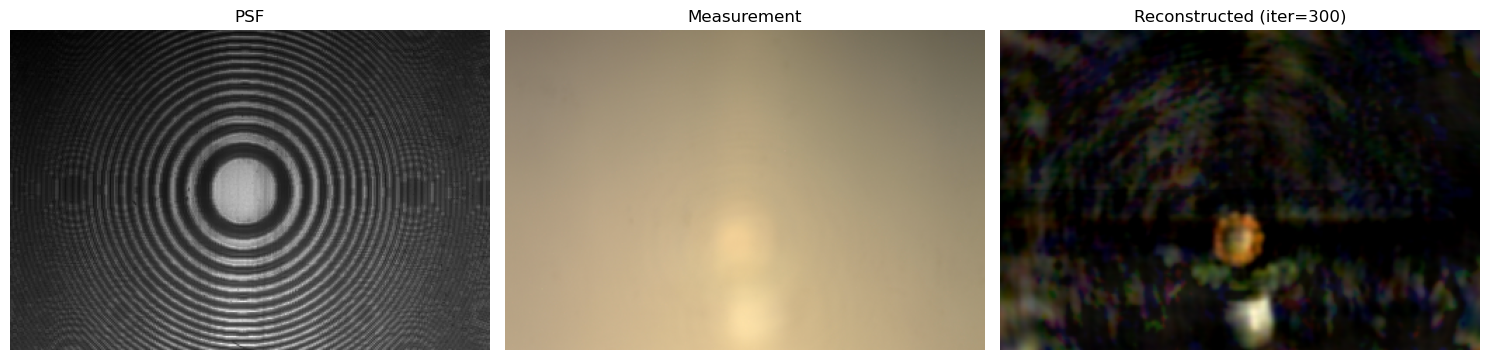

[Saved] PSF saved to: /Users/qiujinyu/Computational_Imaging/ADMMbyQJY/pic/psf.png
[Saved] Measurement saved to: /Users/qiujinyu/Computational_Imaging/ADMMbyQJY/pic/m.png
[Saved] Reconstruction saved to: /Users/qiujinyu/Computational_Imaging/ADMMbyQJY/pic/r.png


In [19]:
visualize_reconstruction(
    psf_resized=psf_resized,
    measurement_resized=np.clip(measurement_resized.transpose(1, 2, 0) / measurement_resized.max(), 0, 1),
    reconstruction=reconstruction,
    ground_truth_file=ground_truth_file,
    iterations=iterations
)
save_all_images(
    psf=psf_resized,
    measurement=np.clip(measurement_resized.transpose(1, 2, 0) / measurement_resized.max(), 0, 1),
    reconstruction=reconstruction,
    ground_truth=ground_truth_file,     # 没有真值就自动跳过
    save_dir=save_dir,                  # 保存路径
    filenames=save_name                 # 可选，默认文件名 psf.png, m.png, r.png
)
